In [1]:
# MISC
import os
import sys
import functools
sys.path.append("..")

os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='1'

from rich.pretty import pprint
from collections import defaultdict
from tqdm.auto import trange
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# RL 
import jax
import jax.numpy as jnp
import gymnasium
import ogbench
import flax.linen as nn

# Custom
from envs.ogbench.ant_utils import MazeVizWrapper
from utils.datasets import Dataset

from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-notebook'])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

GLOBAL_KEY = jax.random.key(42)

In [2]:
from tqdm.auto import trange
from utils.evaluation import add_to, flatten, supply_rng

def evaluate(
    env,
    task_id=None,
    config=None,
    num_eval_episodes=20,
    eval_gaussian=None,
):
    stats = defaultdict(list)
    for i in range(num_eval_episodes):
        traj = defaultdict(list)
        should_render = i >= num_eval_episodes

        observation, info = env.reset(options=dict(task_id=task_id, render_goal=should_render))
        goal = info.get('goal')
        goal_frame = info.get('goal_rendered')
        done = False
        step = 0
        render = []
        while not done:
            action = env.action_space.sample()
            action = np.array(action)
            action = np.clip(action, -1, 1)

            next_observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            step += 1
            observation = next_observation
        if i < num_eval_episodes:
            add_to(stats, flatten(info))
            
    for k, v in stats.items():
        stats[k] = np.mean(v)

    return stats

# Single Layout

In [3]:
env = ogbench.make_env_and_datasets( #  train_dataset, valid_dataset 
    "pointmaze-medium-explore-v0",
    env_only=True, render_mode='rgb_array'
)

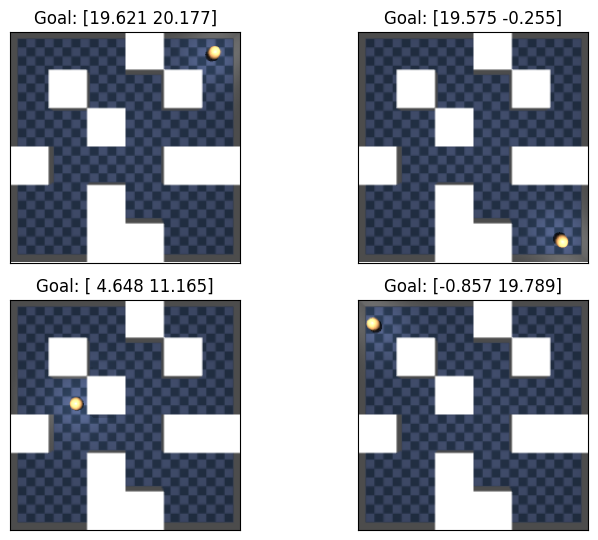

In [4]:
fig, axs = plt.subplots(ncols=2, nrows=2)
axs = axs.flatten()
for idx, task_id in enumerate([1, 2, 3, 4]):
    ob, info = env.reset(
        options=dict(
            task_id=task_id,
            render_goal=True,
        )
    )
    goal = info['goal']
    goal_rendered = info['goal_rendered']
    axs[idx].imshow(goal_rendered)
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])
    axs[idx].set_title(f"Goal: {np.round(goal, 3)}")
plt.tight_layout()
env.close()

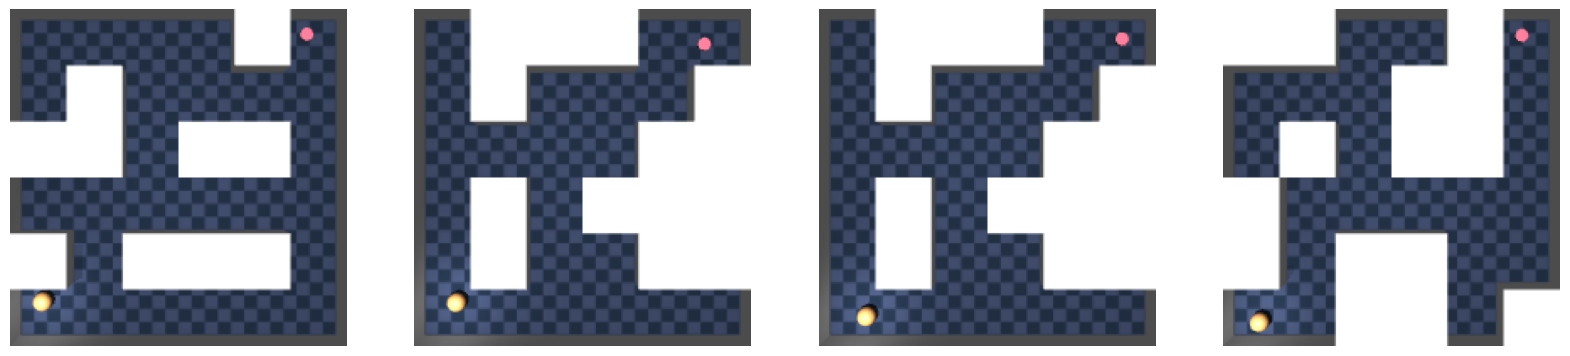

In [5]:
def render_maze(index, ax=None):
    maze = gymnasium.make(f'pointmaze-medium-layout-{index}', render_mode='rgb_array')
    ob, info = maze.reset(options=dict(collect=False))
    frame = maze.render()
    if ax is None:
        plt.imshow(frame)
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(frame)
        ax.axis('off')
    maze.close()

fig, ax = plt.subplots(figsize=(20, 8), nrows=1, ncols=4)
for i, cur_ax in enumerate(ax.flatten()):
    i = np.random.randint(10)
    render_maze(index=i, ax=cur_ax)
render_maze(0)

{'actions': (12450, 2), 'next_observations': (12450, 2), 'observations': (12450, 2), 'terminals': (12450,)}

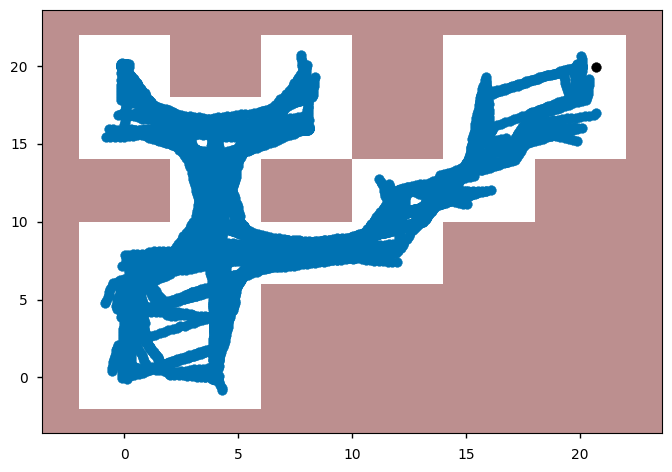

In [6]:
from ogbench.utils import load_dataset

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = []
NUM_TRAIN_LAYOUTS = 1

for i in range(1, NUM_TRAIN_LAYOUTS + 1):
    cur_data = load_dataset(f"../aux_data/pointmaze-layout-{i}.npz")
    whole_data.append(cur_data)

whole_data = functools.reduce(concatenate_dicts, whole_data)
pprint(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))

env = gymnasium.make("pointmaze-medium-layout-1", render_mode='rgb_array')
env = MazeVizWrapper(env)
ob, info = env.reset(options=dict(collect=False))

fig, ax = plt.subplots()
polygons = env.draw(ax=ax)
ax.scatter(whole_dataset['observations'].reshape(-1, 2)[:10000 - 300, 0], whole_dataset['observations'].reshape(-1, 2)[:10000-300, 1])
goal = info.get('goal')
ax.scatter(goal[0], goal[1], c='black')

In [7]:
from ogbench.utils import load_dataset

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = []
NUM_TRAIN_LAYOUTS = 3

for i in range(1, NUM_TRAIN_LAYOUTS + 1):
    cur_data = load_dataset(f"../aux_data/pointmaze-layout{i}.npz")
    whole_data.append(cur_data)

whole_data = functools.reduce(concatenate_dicts, whole_data)
pprint(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))

env = gymnasium.make("pointmaze-medium-layout-1", render_mode='rgb_array')
env = MazeVizWrapper(env)
ob, info = env.reset()

{'actions': (60000, 2), 'next_observations': (60000, 2), 'observations': (60000, 2), 'terminals': (60000,)}

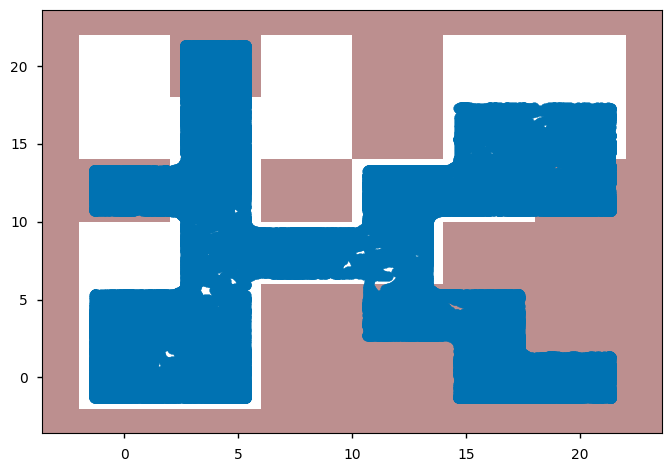

In [8]:
fig, ax = plt.subplots()
polygons = env.draw(ax=ax)
ax.scatter(whole_dataset['observations'].reshape(-1, 2)[:20_000, 0], whole_dataset['observations'].reshape(-1, 2)[:20_000, 1])

# Train FB

In [9]:
import functools
from utils.datasets import Dataset, GCDataset

from ogbench.utils import load_dataset

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = []
NUM_TRAIN_LAYOUTS = 4

for i in range(1, NUM_TRAIN_LAYOUTS + 1):
    cur_data = load_dataset(f"../aux_data/pointmaze-layout-{i}.npz")
    whole_data.append(cur_data)

whole_data = functools.reduce(concatenate_dicts, whole_data)
pprint(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))

with initialize(version_base=None, config_path="../configs/"):
    fb_config = compose(config_name='entry.yaml', overrides=['experiment=fb_ogbench.yaml'])
    fb_config = OmegaConf.to_container(fb_config, resolve=True)
    pprint(fb_config)

gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])

sys.path.append("..")
from agents.fb import ForwardBackwardAgent

gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])
example_batch = gc_whole_dataset.sample(1)
fb_agent = ForwardBackwardAgent.create(
    0,
    example_batch['observations'],
    example_batch['actions'],
    config=fb_config['agent']
)
batch = gc_whole_dataset.sample(1)
fb_agent, info = fb_agent.update(batch)

{'actions': (49800, 2), 'next_observations': (49800, 2), 'observations': (49800, 2), 'terminals': (49800,)}

{
│   'seed': 42,
│   'run_group': 'fb',
│   'save_dir': 'experiment_logs/',
│   'train_steps': 1000000,
│   'log_interval': 10000,
│   'eval_interval': 100000,
│   'eval_tasks': None,
│   'eval_episodes': 20,
│   'eval_temperature': 0,
│   'eval_gaussian': None,
│   'video_episodes': 1,
│   'video_frame_skip': 3,
│   'eval_on_cpu': 0,
│   'frame_stack': None,
│   'p_aug': None,
│   'agent': {
│   │   'agent_name': 'fb',
│   │   'lr': 0.0001,
│   │   'batch_size': 1024,
│   │   'discrete': False,
│   │   'discount': 0.99,
│   │   'tau': 0.01,
│   │   'clip_by_global_norm': True,
│   │   'dataset_class': 'GCDataset',
│   │   'value_p_curgoal': 0.0,
│   │   'value_p_trajgoal': 1.0,
│   │   'value_p_randomgoal': 0.0,
│   │   'value_geom_sample': True,
│   │   'actor_p_curgoal': 0.0,
│   │   'actor_p_trajgoal': 0.0,
│   │   'actor_p_randomgoal': 1.0,
│   │   'actor_geom_sample': False,
│   │   'gc_negative': True,
│   │   'p_aug': 0.0,
│   │   'frame_stack': None,
│   │   'use_context': False,
│   │   'z_dim': 50,
│   │   'z_mix_ratio': 0.5,
│   │   'f_hidden_dims': [1024, 1024, 1024],
│   │   'f_layer_norm': True,
│   │   'f_preprocessor_hidden_dims': [1024, 1024, 512],
│   │   'f_activate_final': False,
│   │   'b_hidden_dims': [512, 512, 512],
│   │   'b_layer_norm': True,
│   │   'actor_hidden_dims': [1024, 1024, 1024],
│   │   'actor_preprocessor_hidden_dims': [1024, 1024, 512],
│   │   'actor_preprocessor_layer_norm': True,
│   │   'actor_preprocessor_activate_final': False,
│   │   'tanh_squash': True,
│   │   'state_dependent_std': False,
│   │   'actor_fc_scale': 0.01,
│   │   'const_std': True
│   },
│   'env': {'env_name': 'ogbench-pointmaze-medium-stitch-v0', 'discrete': False},
│   'tags': ['fb_vanilla', 'ogbench']
}

In [10]:
def evaluate(
    agent,
    env,
    task_id=None,
    config=None,
    num_eval_episodes=10,
    num_video_episodes=0,
    video_frame_skip=2,
    eval_temperature=0.0,
    eval_gaussian=None,
):
    actor_fn = supply_rng(agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32)))
    trajs = []
    stats = defaultdict(list)
    pbar = trange(num_eval_episodes + num_video_episodes, leave=False, colour='red', position=2)
    renders = []
    for i in pbar:
        traj = defaultdict(list)
        should_render = i >= num_eval_episodes

        observation, info = env.reset()
        goal = info.get('goal')
        goal_frame = info.get('goal_rendered')
        done = False
        step = 0
        render = []
        latent_z = agent.infer_z(goal)
        while not done:
            action = actor_fn(observations=observation, latent_z=latent_z, temperature=eval_temperature)
            action = np.array(action)
            if eval_gaussian is not None:
                action = np.random.normal(action, eval_gaussian)
            action = np.clip(action, -1, 1)

            next_observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            step += 1

            if should_render and (step % video_frame_skip == 0 or done):
                frame = env.render().copy()
                if goal_frame is not None:
                    render.append(np.concatenate([goal_frame, frame], axis=0))
                else:
                    render.append(frame)

            transition = dict(
                observation=observation,
                next_observation=next_observation,
                action=action,
                reward=reward,
                done=done,
                info=info,
            )
            add_to(traj, transition)
            observation = next_observation
        if i < num_eval_episodes:
            add_to(stats, flatten(info))
            trajs.append(traj)
        else:
            renders.append(np.array(render))

    for k, v in stats.items():
        stats[k] = np.mean(v)

    return stats, trajs

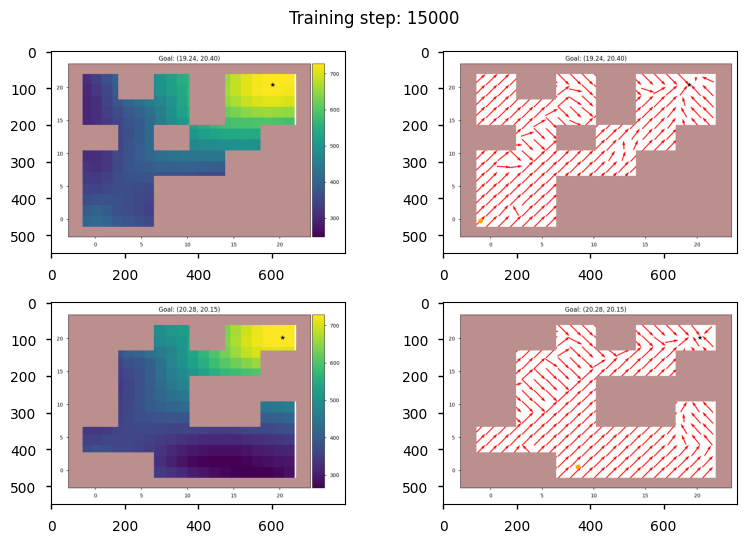

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
from envs.ogbench.ant_utils import policy_image, value_image
from functools import partial
from utils.evaluation import flatten, supply_rng
from IPython.display import clear_output

pbar = tqdm(range(1_000_000))
env_num = 0
eval_env = gymnasium.make("pointmaze-medium-layout-1", render_mode='rgb_array', max_episode_steps=250)
eval_env = MazeVizWrapper(eval_env)

eval_env2 = gymnasium.make("pointmaze-medium-layout-2", render_mode='rgb_array', max_episode_steps=250)
eval_env2 = MazeVizWrapper(eval_env2)

eval_stats = []
for step in pbar:
    key = jax.random.fold_in(GLOBAL_KEY, step)
    batch = gc_whole_dataset.sample(1024)
    fb_agent, update_info = fb_agent.update(batch)

    if step % 11_000 == 0:
        stats, _ = evaluate(fb_agent, eval_env)
        eval_stats.append(stats['success'])
        
    if step % 15_000 == 0:
        clear_output()      
        fig, ax = plt.subplots(nrows=2, ncols=2)
        observation, info = eval_env.reset()
        goal = info.get('goal')
        start = observation
        latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
        
        N, M = 14, 20
        latent_z = np.tile(latent_z, (N * M, 1))
        pred_value_img = value_image(eval_env, example_batch, N=N, M=M,
                                    value_fn=partial(fb_agent.predict_q, z=latent_z),
                                    action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=0.0),
                                    goal=goal)
        pred_policy_img = policy_image(eval_env, example_batch, N=N, M=M,
                                    action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=0.0),
                                    goal=goal, start=start)
        
        ax[0, 0].imshow(pred_value_img)
        ax[0, 1].imshow(pred_policy_img)
        
        observation, info = eval_env2.reset()
        goal = info.get('goal')
        start = observation
        latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
        
        N, M = 14, 20
        latent_z = np.tile(latent_z, (N * M, 1))
        pred_value_img = value_image(eval_env2, example_batch, N=N, M=M,
                                    value_fn=partial(fb_agent.predict_q, z=latent_z),
                                    action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=0.0),
                                    goal=goal)
        pred_policy_img = policy_image(eval_env2, example_batch, N=N, M=M,
                                    action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=0.0),
                                    goal=goal, start=start)
        
        ax[1, 0].imshow(pred_value_img)
        ax[1, 1].imshow(pred_policy_img)
        fig.suptitle(f"Training step: {step}")  
        plt.tight_layout()
        display(fig)
        plt.close(fig)

In [53]:
from envs.ogbench.ant_utils import policy_image, value_image
from functools import partial
from utils.evaluation import evaluate, evaluate_fourrooms, flatten, supply_rng

env = gymnasium.make("pointmaze-medium-layout2", render_mode='rgb_array')
env = MazeVizWrapper(env)

observation, info = env.reset(options=dict(task_id=2, render_goal=True))
goal = info.get('goal')
start = env.unwrapped.get_xy()
latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
N, M = 14, 20
latent_z = np.tile(latent_z, (N * M, 1))
pred_value_img = value_image(env, example_batch, N=N, M=M,
                            value_fn=partial(fb_agent.predict_q, z=latent_z),
                            action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=0.0),
                            goal=goal)
pred_policy_img = policy_image(env, example_batch, N=N, M=M,
                            action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=0.0),
                            goal=goal, start=start)

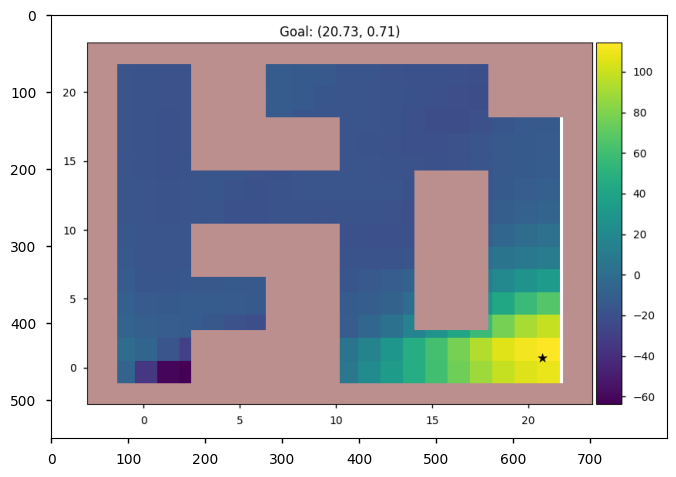

In [54]:
plt.imshow(pred_value_img)